In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## 1. Face detection


### Assignment

Here's what you are required to do for this part of the assignment.

- You are provided with a small dataset of pictures, where each picture contains exactly one face. Extract the faces and their labels (i.e., the person's names). Store them to a new file with the function `dump` in the package `pickle`.


-  Normalize the cropped faces (i.e., divide the pixel values by 255), and split them in train set (70%) and test set (30%) with the function `train_test_split` in the package `sklearn`. 


- Train a small convnet and check its performance on the test set. Remember: don't use the test images for training.


- Try to improve the performance of the baseline convnet by using all the tricks you have learned in the course.

Usefull Functions


In [ ]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('/content/drive/MyDrive/DeepLearning/models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):
    
    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10
            
    matches = detector(image,1)
    rects   = []
    
    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))
        
    return rects

In [ ]:
def extract_faces(image, model="hog"):
    
    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []
    
    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)
            
    return faces

In [ ]:
def show_grid(faces, figsize=(12,3)):

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))
    
    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

            

In [ ]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):
    
    imagePaths = []
    
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)
    
    return imagePaths

Nous importons le dataset contenant 35 images de 6 acteurs différents, soit 210 images.

In [ ]:
imagePaths = list_images("/content/drive/MyDrive/DeepLearning/data")
imagePaths

['/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000010.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000036.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000019.png',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000033.png',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000015.png',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000029.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000012.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000014.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000031.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000025.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000023.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000001.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_dearing/00000018.jpg',
 '/content/drive/MyDrive/DeepLearning/data/claire_d

In [ ]:
faces, labels = [], []

for imagePath in imagePaths :
  #Extraction du label à partir du nom du fichier
  name = imagePath.split('/')[6]
  #Extraction du visage sur chaque image
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  face = extract_faces(image, model="cnn")
  #Cette condition s'assure qu'un visage ai bien été détecté
  if len(face) == 1:
    labels.append(name)
    faces+=face

On enregistre les images des visages extrait et leur label dans un fichier à l'aide de la fonction `dump` du package `pickle`.

Le module `pickle` écrit les données uniquement dans un fichier ouvert en mode binaire.

In [ ]:
from pickle import dump

file = open('dataset', 'wb')
dump((faces, labels), file)
file.close()

Nous chargeons le dataset de notre fichier

In [ ]:
from pickle import load

file = open('dataset','rb')
faces,labels = load(file)

Normalisation de faces :

In [ ]:
faces = np.array(faces).astype('float32')/255

On convertit les labels qui sont des chaines de caractères en int
car la fonction to_categorical (pour le one hot encoding) ne fonctionne qu'avec
des entiers :

In [ ]:
from tensorflow.keras.utils import to_categorical

#On convertit les labels qui sont des chaines de caractères en int
#car la fonction to_categorical (pour le one hot encoding) ne fonctionne qu'avec
#des entiers.
names = {'alan_grant':0, 'claire_dearing':1, 'ellie_sattler':2, 'ian_malcolm':3,
         'john_hammond':4, 'owen_grady':5}

category = [names[label] for label in labels]
category = to_categorical(category)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set, train_labels, test_labels = train_test_split(faces, category,train_size=0.7, shuffle=True)

In [ ]:
from keras import utils, layers, models, optimizers

# Define the network
model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.SeparableConv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'] )

# Train the network. Hint: use .fit(...)
history = model.fit(
      train_set, train_labels,
      epochs=60,
      validation_data=(test_set,test_labels))


Epoch 1/60
5/5 [==============================] - 2s 138ms/step - loss: 1.7739 - accuracy: 0.2292 - val_loss: 1.7350 - val_accuracy: 0.2381
Epoch 2/60
5/5 [==============================] - 0s 33ms/step - loss: 1.7117 - accuracy: 0.2639 - val_loss: 1.7145 - val_accuracy: 0.2381
Epoch 3/60
5/5 [==============================] - 0s 32ms/step - loss: 1.6784 - accuracy: 0.2778 - val_loss: 1.7004 - val_accuracy: 0.2540
Epoch 4/60
5/5 [==============================] - 0s 30ms/step - loss: 1.6402 - accuracy: 0.3681 - val_loss: 1.6773 - val_accuracy: 0.2540
Epoch 5/60
5/5 [==============================] - 0s 31ms/step - loss: 1.5963 - accuracy: 0.3542 - val_loss: 1.6374 - val_accuracy: 0.2698
Epoch 6/60
5/5 [==============================] - 0s 31ms/step - loss: 1.5493 - accuracy: 0.4167 - val_loss: 1.5890 - val_accuracy: 0.3492
Epoch 7/60
5/5 [==============================] - 0s 30ms/step - loss: 1.4933 - accuracy: 0.4722 - val_loss: 1.5650 - val_accuracy: 0.3968
Epoch 8/60
5/5 [==========

Performance du convnet :

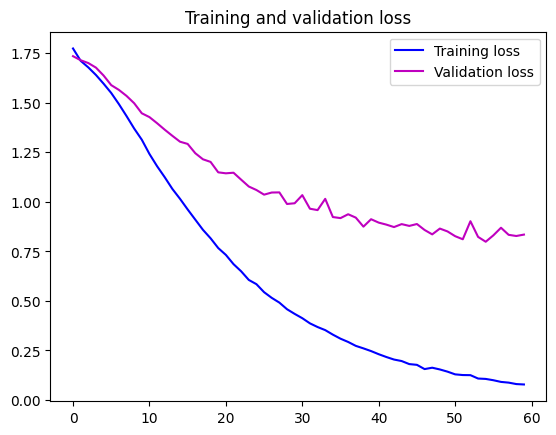

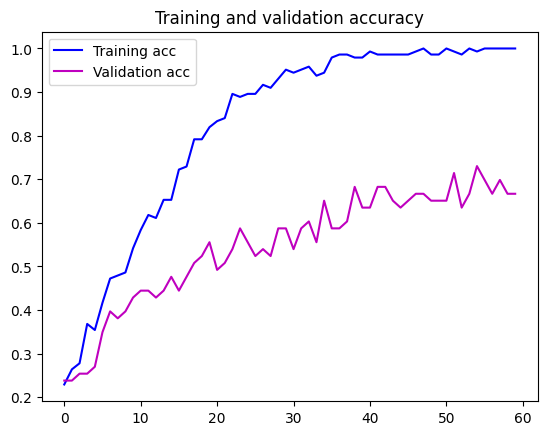

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

On remarque qu'il y a de l'overfitting. (Validation loss et accuracy ne suivent pas les courbes du training)

Pour palier ce problème, utilisons la data augmentation.

Pour cela, on met en place un générateur d'images :

Importation du dataset pour le générateur :

In [ ]:
imagePaths = list_images("/content/drive/MyDrive/DeepLearning/data_augmente")
imagePaths

In [ ]:
faces, labels = [], []

for imagePath in imagePaths :
  #Extraction du visage sur chaque image
  image = cv2.imread(imagePath)
  face = extract_faces(image, model="cnn")
  #Cette condition s'assure qu'un visage ai bien été détecté
  if len(face) == 1:
    cv2.imwrite(imagePath, face[0]) #Remplace les images originales par les nouvelles contenant uniquement les visages

In [ ]:
train_dir = "/content/drive/MyDrive/DeepLearning/data_augmente/train/"
test_dir = "/content/drive/MyDrive/DeepLearning/data_augmente/test/"
validation_dir = "/content/drive/MyDrive/DeepLearning/data_augmente/validation/"

Création des générateurs d'images :

In [ ]:
from keras.preprocessing import image

# All images will be rescaled by 1./255
train_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,           # This is the directory where the images are stored
        target_size=(128, 128), # All images will be resized to 128x128
        batch_size=32,
        class_mode='categorical'     # Since there are only several classes, we need categorical labels
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 135 images belonging to 6 classes.
Found 42 images belonging to 6 classes.
Found 42 images belonging to 6 classes.


data batch shape: (32, 128, 128, 3)
[0. 0. 0. 0. 0. 1.]


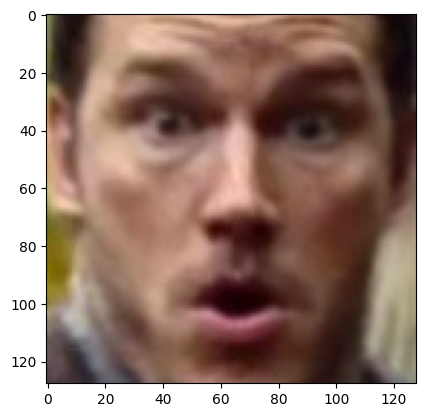

In [ ]:
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img

for data_batch, labels_batch in validation_generator:
    
    print('data batch shape:', data_batch.shape)
    
    plt.imshow(array_to_img(data_batch[0]))
    print(labels_batch[0])
    plt.show()
    
    break

Déformation à appliquer aux images du générateur :

In [ ]:
datagen = image.ImageDataGenerator(
    #rescale=1./255, 
    rotation_range=50, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest')

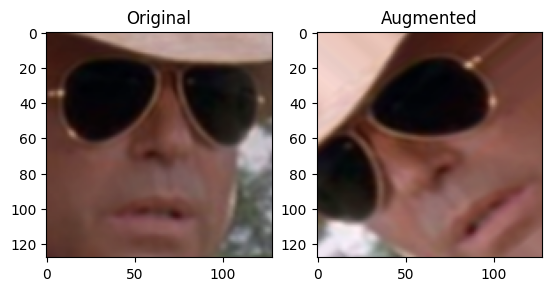

In [ ]:
# We pick one image to "augment"
img = load_img(train_dir+"alan_grant/00000004.png", target_size=(128, 128))

# Convert it to a Numpy array with shape (128, 128, 3)
x = img_to_array(img)

# Reshape it to (1, 128, 128, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
batch = datagen.flow(x, batch_size=1)[0]

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(img)
plt.title("Original")

fig.add_subplot(122)
plt.imshow(array_to_img(batch[0]))
plt.title("Augmented")

plt.show()

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 135 images belonging to 6 classes.


Entrainons maintenant notre modèle en utilisant la data augmentation :

batch_size = 20 

len(X_train) = 135

len(X_test) = 42

Donc :
steps_per_epoch = 6
validation_steps = 2

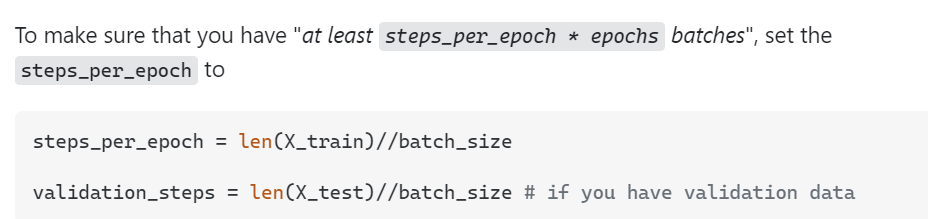

In [ ]:
from keras import utils, layers, models, optimizers

model2 = models.Sequential()
model2.add(layers.SeparableConv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.SeparableConv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'] )

history = model2.fit(
      train_generator,
      steps_per_epoch = 6,
      epochs=60,
      validation_data=validation_generator,)

Epoch 1/60
6/6 [==============================] - 2s 290ms/step - loss: 1.8385 - accuracy: 0.2348 - val_loss: 1.7624 - val_accuracy: 0.2619
Epoch 2/60
6/6 [==============================] - 1s 190ms/step - loss: 1.7420 - accuracy: 0.2609 - val_loss: 1.7344 - val_accuracy: 0.2619
Epoch 3/60
6/6 [==============================] - 1s 152ms/step - loss: 1.7403 - accuracy: 0.2609 - val_loss: 1.7170 - val_accuracy: 0.3095
Epoch 4/60
6/6 [==============================] - 1s 164ms/step - loss: 1.7022 - accuracy: 0.2696 - val_loss: 1.7022 - val_accuracy: 0.2381
Epoch 5/60
6/6 [==============================] - 1s 151ms/step - loss: 1.6890 - accuracy: 0.2435 - val_loss: 1.6902 - val_accuracy: 0.2381
Epoch 6/60
6/6 [==============================] - 1s 155ms/step - loss: 1.6763 - accuracy: 0.2522 - val_loss: 1.6607 - val_accuracy: 0.3333
Epoch 7/60
6/6 [==============================] - 1s 159ms/step - loss: 1.6445 - accuracy: 0.3565 - val_loss: 1.6400 - val_accuracy: 0.3810
Epoch 8/60
6/6 [====

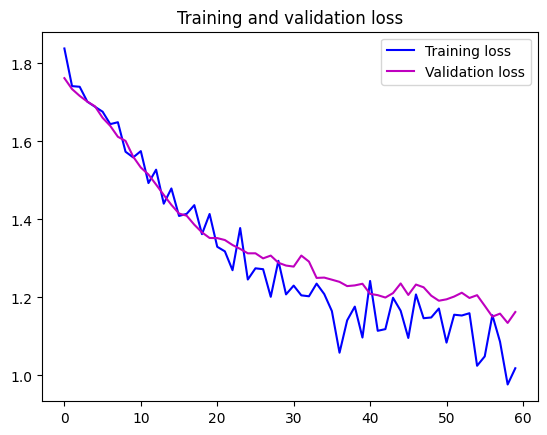

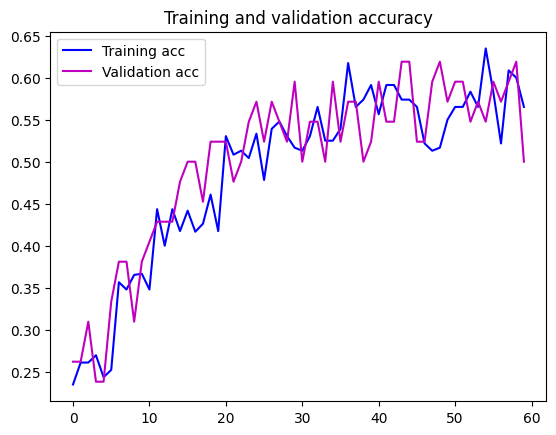

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

Nous voyons que la méthode de data augmentation réduit le problème d'overfitting.
La précision n'est cependant pas améliorée

Ajoutons maintenant des dropout layers :

In [ ]:
from keras import utils, layers, models, optimizers

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'] )

history = model2.fit(
      train_generator,
      epochs=60,
      validation_data=validation_generator)

Epoch 1/60
7/7 [==============================] - 2s 231ms/step - loss: 2.2610 - accuracy: 0.1630 - val_loss: 1.7351 - val_accuracy: 0.2857
Epoch 2/60
7/7 [==============================] - 1s 205ms/step - loss: 1.9135 - accuracy: 0.2815 - val_loss: 1.7049 - val_accuracy: 0.3095
Epoch 3/60
7/7 [==============================] - 1s 146ms/step - loss: 1.8737 - accuracy: 0.2593 - val_loss: 1.7041 - val_accuracy: 0.3333
Epoch 4/60
7/7 [==============================] - 1s 140ms/step - loss: 1.7549 - accuracy: 0.2815 - val_loss: 1.6972 - val_accuracy: 0.3333
Epoch 5/60
7/7 [==============================] - 1s 140ms/step - loss: 1.6595 - accuracy: 0.3259 - val_loss: 1.6865 - val_accuracy: 0.3810
Epoch 6/60
7/7 [==============================] - 1s 140ms/step - loss: 1.6357 - accuracy: 0.3111 - val_loss: 1.6805 - val_accuracy: 0.4286
Epoch 7/60
7/7 [==============================] - 1s 200ms/step - loss: 1.5823 - accuracy: 0.4148 - val_loss: 1.6610 - val_accuracy: 0.4286
Epoch 8/60
7/7 [====

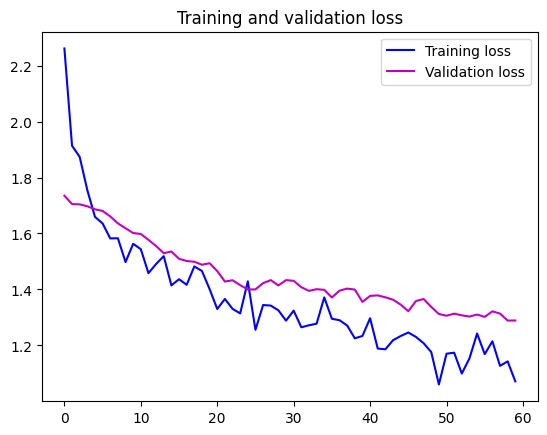

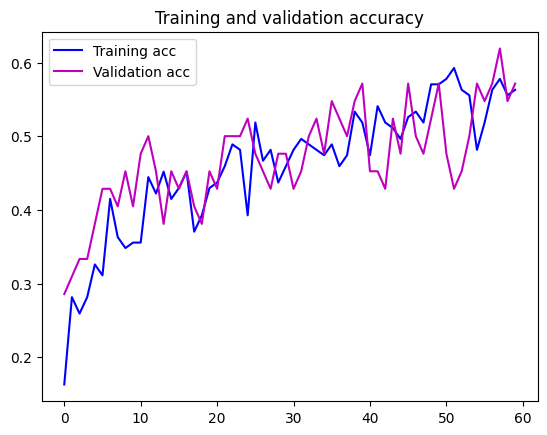

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

L'ajout de dropout layers améliore légerement la précision

Ajoutons la L2-norm penalization pour réduire l'overfitting :

In [ ]:
from keras import utils, layers, models, optimizers, regularizers

model2 = models.Sequential()
model2.add(layers.SeparableConv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128,128,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.SeparableConv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.25))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'] )

history = model2.fit(
      train_generator,
      epochs=60,
      validation_data=validation_generator)

Epoch 1/60
7/7 [==============================] - 7s 699ms/step - loss: 1.8114 - accuracy: 0.2148 - val_loss: 1.7442 - val_accuracy: 0.1667
Epoch 2/60
7/7 [==============================] - 2s 249ms/step - loss: 1.7672 - accuracy: 0.2667 - val_loss: 1.7056 - val_accuracy: 0.3571
Epoch 3/60
7/7 [==============================] - 1s 145ms/step - loss: 1.7102 - accuracy: 0.3111 - val_loss: 1.6785 - val_accuracy: 0.4048
Epoch 4/60
7/7 [==============================] - 1s 140ms/step - loss: 1.5921 - accuracy: 0.3630 - val_loss: 1.6622 - val_accuracy: 0.4286
Epoch 5/60
7/7 [==============================] - 1s 140ms/step - loss: 1.6137 - accuracy: 0.3407 - val_loss: 1.6296 - val_accuracy: 0.4048
Epoch 6/60
7/7 [==============================] - 1s 140ms/step - loss: 1.6124 - accuracy: 0.3111 - val_loss: 1.6071 - val_accuracy: 0.3571
Epoch 7/60
7/7 [==============================] - 1s 141ms/step - loss: 1.5825 - accuracy: 0.3852 - val_loss: 1.5975 - val_accuracy: 0.4286
Epoch 8/60
7/7 [====

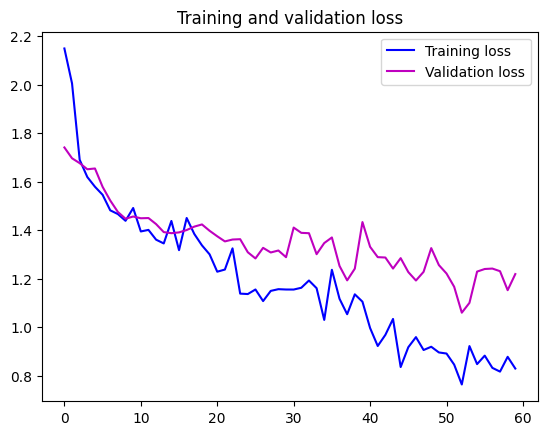

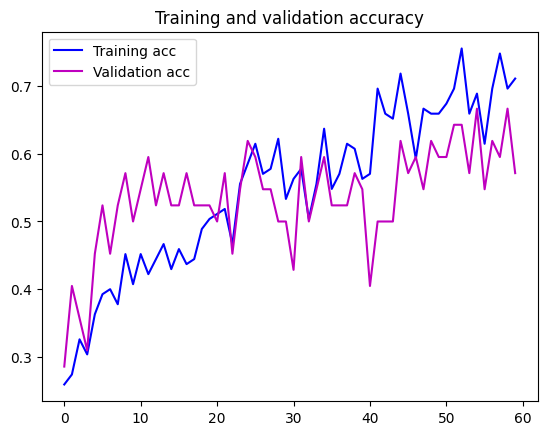

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=2)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

2/2 [==============================] - 0s 27ms/step - loss: 0.8670 - accuracy: 0.7381
Test accuracy: 73.81%


## 2. Pose estimation

### Assignment

Here's what you are required to do for this part of the assignment.

- Further preprocess the face pictures by correcting their pose. You should now have a dataset of cropped, aligned, and normalized faces.


- Re-train your convnets on the modified dataset. 


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

Usefull Functions

In [ ]:
pose68 = dlib.shape_predictor('/content/drive/MyDrive/DeepLearning/models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('/content/drive/MyDrive/DeepLearning/models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):
    
    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05
    
    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [ ]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [ ]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [ ]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

In [ ]:
from pickle import load
file = open('dataset', 'rb')
faces, labels = load(file)
file.close()

In [ ]:
landmarks = face_landmarks(faces)

In [ ]:
new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

In [ ]:
aligned = align_faces(new_faces,landmarks)

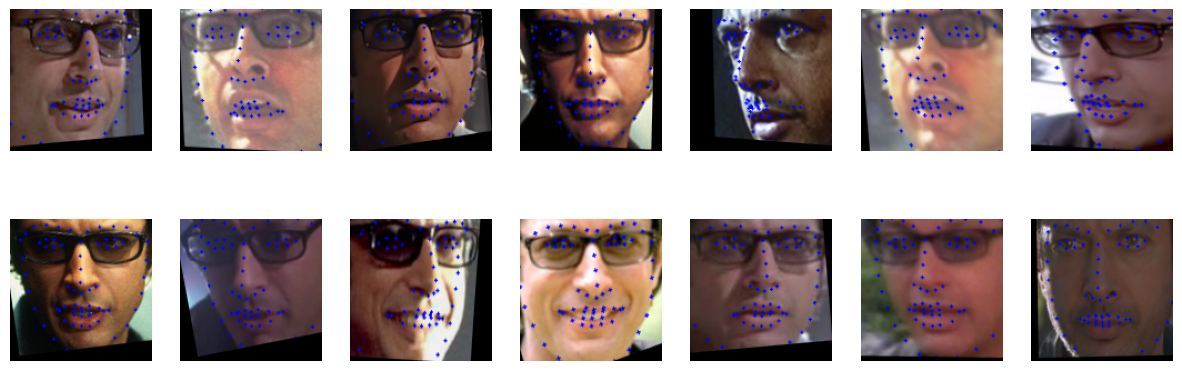

In [ ]:
show_grid(aligned[100:114], figsize=(15,5))

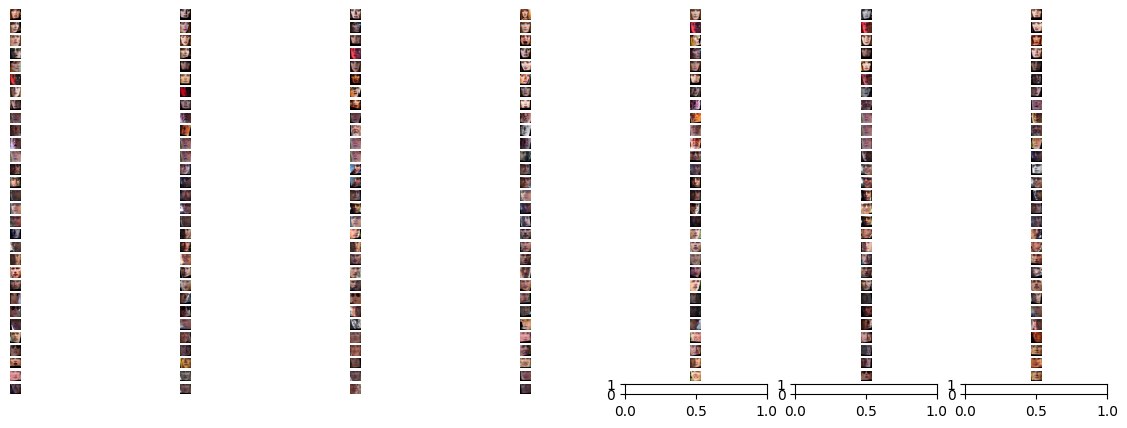

In [ ]:
show_grid(aligned, figsize=(15,5))

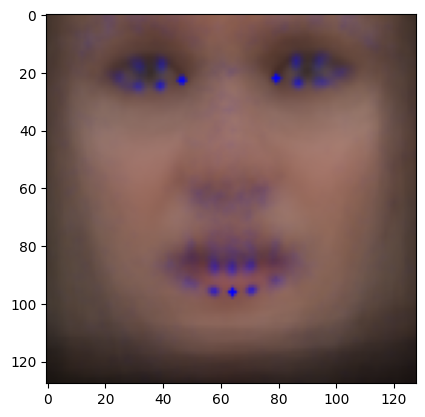

In [ ]:
plt.imshow( np.stack(aligned, axis=3).astype(np.float32).mean(axis=3)/255 )

In [ ]:
category = [names[label] for label in labels]
category = to_categorical(category)

from sklearn.model_selection import train_test_split

train_set_aligned, test_set_aligned, train_labels_aligned, test_labels_aligned = train_test_split(np.array(aligned)/255, category, train_size=0.7, shuffle=True) 

Utilisons la L2-norm penalization :

In [ ]:
from keras import regularizers

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(128,128,3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Dropout(0.5))


model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'] )

history = model2.fit(
      train_set_aligned, train_labels_aligned,
      epochs=100,
      validation_data=(test_set_aligned,test_labels_aligned))

Epoch 1/100
5/5 [==============================] - 2s 151ms/step - loss: 4.0507 - accuracy: 0.1667 - val_loss: 2.9562 - val_accuracy: 0.1746
Epoch 2/100
5/5 [==============================] - 0s 46ms/step - loss: 2.9812 - accuracy: 0.2639 - val_loss: 2.7334 - val_accuracy: 0.3175
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 2.7158 - accuracy: 0.3681 - val_loss: 2.7029 - val_accuracy: 0.3810
Epoch 4/100
5/5 [==============================] - 0s 36ms/step - loss: 2.7040 - accuracy: 0.3681 - val_loss: 2.6808 - val_accuracy: 0.4127
Epoch 5/100
5/5 [==============================] - 0s 36ms/step - loss: 2.5647 - accuracy: 0.3611 - val_loss: 2.6783 - val_accuracy: 0.4762
Epoch 6/100
5/5 [==============================] - 0s 35ms/step - loss: 2.4150 - accuracy: 0.4653 - val_loss: 2.6659 - val_accuracy: 0.4762
Epoch 7/100
5/5 [==============================] - 0s 34ms/step - loss: 2.4264 - accuracy: 0.4653 - val_loss: 2.5876 - val_accuracy: 0.5397
Epoch 8/100
5/5 [==

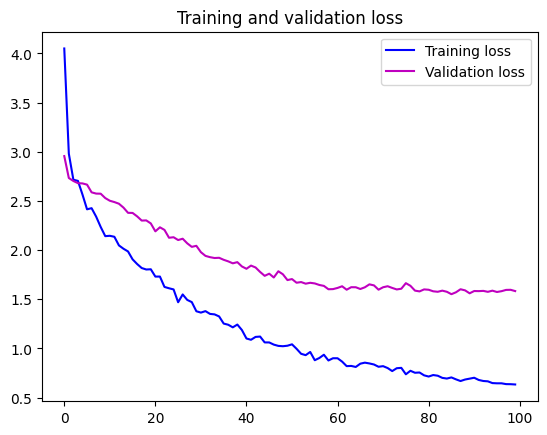

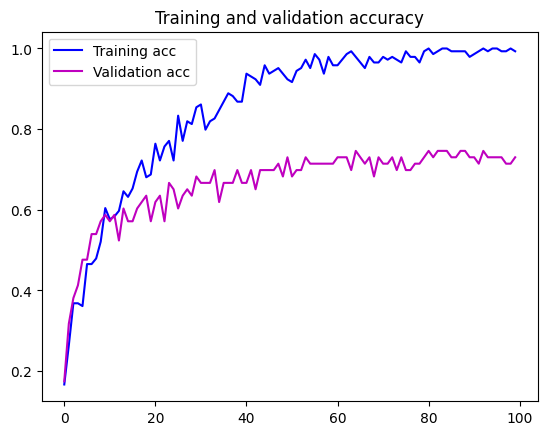

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## 3. Face encoding

### Assignment

Here's what you are required to do for this part of the assignment.

- Preprocess the cropped faces by encoding them. You should now have a dataset of cropped and encoded faces.


- Train a neural network on the modified dataset. Since the encoded faces are just 128-length vectors, **you don't need a convnet**. Use a regular neural network with a series of fully-connected layers.


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

#### Provided functions

In [ ]:
cnn_encoder = dlib.face_recognition_model_v1('/content/drive/MyDrive/DeepLearning/models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):
    
    landmarks = face_landmarks(faces)
    
    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

On charge les faces et labels associés précedemment dans le TP

In [ ]:
from pickle import load
file = open('dataset', 'rb')
faces, labels = load(file)
file.close()

On encode chacune des images à l'aide de la fonction fournie face_encoder() qui prend les 128 mesures les plus importantes d'un visage.

L'alignement des visages est intégré à la fonction.

In [ ]:
encoded_faces = face_encoder(faces)

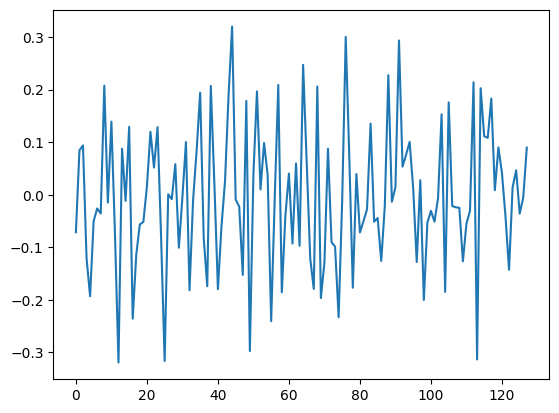

In [ ]:
plt.plot(encoded_faces[0])

In [ ]:
category = [names[label] for label in labels]
category = to_categorical(category)

from sklearn.model_selection import train_test_split

train_set_encoded, test_set_encoded, train_labels_encoded, test_labels_encoded = train_test_split(encoded_faces, category, train_size=0.7, shuffle=True) 

In [ ]:
print(train_set_encoded.shape)
print(test_set_encoded.shape)
print(train_labels_encoded.shape)
print(test_labels_encoded.shape)

(144, 128)
(63, 128)
(144, 6)
(63, 6)


On entraine un Fully-connected neural network sur les visages encodés :

In [ ]:
model_encoded = models.Sequential()
model_encoded.add(layers.Dense(512, activation='relu', input_shape=(128,)))
model_encoded.add(layers.Dense(128, activation='relu'))
model_encoded.add(layers.Dense(64, activation='relu'))

model_encoded.add(layers.Dense(6, activation='softmax'))
model_encoded.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy']) # ADD CODE HERE


history = model_encoded.fit(
    train_set_encoded, train_labels_encoded,
    validation_data=(test_set_encoded, test_labels_encoded),
    batch_size=32,
    epochs=50)


Epoch 1/50
5/5 [==============================] - 1s 50ms/step - loss: 1.7859 - accuracy: 0.2222 - val_loss: 1.7758 - val_accuracy: 0.2698
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 1.7632 - accuracy: 0.3264 - val_loss: 1.7586 - val_accuracy: 0.3016
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 1.7461 - accuracy: 0.4097 - val_loss: 1.7432 - val_accuracy: 0.4762
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 1.7294 - accuracy: 0.5347 - val_loss: 1.7283 - val_accuracy: 0.6349
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 1.7135 - accuracy: 0.6597 - val_loss: 1.7133 - val_accuracy: 0.7302
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 1.6965 - accuracy: 0.7292 - val_loss: 1.6974 - val_accuracy: 0.7460
Epoch 7/50
5/5 [==============================] - 0s 10ms/step - loss: 1.6787 - accuracy: 0.7361 - val_loss: 1.6812 - val_accuracy: 0.7460
Epoch 8/50
5/5 [===========

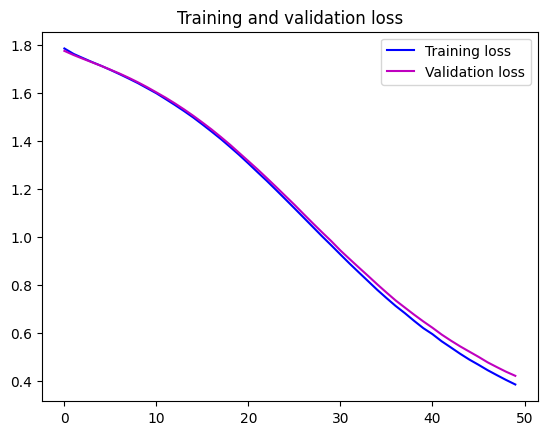

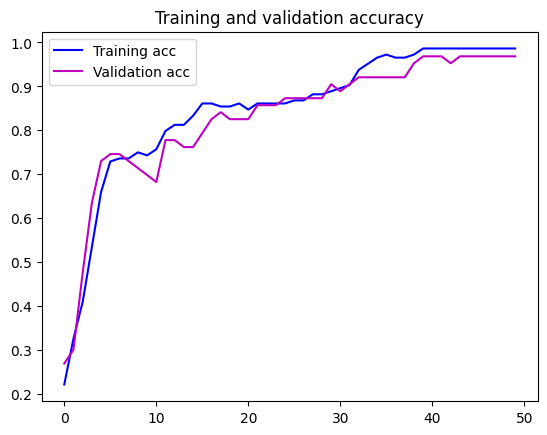

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

## 4. Face recognition
### Assignment

Here's what you are required to do for this part of the assignment.

-  Train several classifiers (logistic regression, SVM, kNN, neural network) on the dataset of encoded faces (you can use the package `scikit-learn`).

- Evaluate their performance on the test set, in terms of accuracy and speed.

- Finally, run your best classifier on the test images and video available in the `test` folder.

In [ ]:
from pickle import load
file = open('dataset', 'rb')
faces, labels = load(file)
file.close()

In [ ]:
from tensorflow.keras.utils import to_categorical

#On convertit les labels qui sont des chaines de caractères en int
#car la fonction to_categorical (pour le one hot encoding) ne fonctionne qu'avec
#des entiers.
names = {'alan_grant':0, 'claire_dearing':1, 'ellie_sattler':2, 'ian_malcolm':3,
         'john_hammond':4, 'owen_grady':5}

category = [names[label] for label in labels]
category = to_categorical(category)

encoded_faces = face_encoder(faces)

train_set_encoded, test_set_encoded, train_labels_encoded, test_labels_encoded = train_test_split(encoded_faces, category, train_size=0.7, shuffle=True) 

from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier(n_neighbors=2)
modelKNN.fit(train_set_encoded, train_labels_encoded)




def process_frame(image, model, names, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        
        # face classification
        prediction = model.predict(np.array(encoding).reshape(1,128))[0]
        label = names[np.argmax(prediction)]
        
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
    return image

list_names = ['alan_grant', 'claire_dearing', 'ellie_sattler', 'ian_malcolm', 'john_hammond', 'owen_grady']

In [ ]:
from tensorflow.keras.utils import to_categorical

#On convertit les labels qui sont des chaines de caractères en int
#car la fonction to_categorical (pour le one hot encoding) ne fonctionne qu'avec
#des entiers.
names = {'alan_grant':0, 'claire_dearing':1, 'ellie_sattler':2, 'ian_malcolm':3,
         'john_hammond':4, 'owen_grady':5}

category = [names[label] for label in labels]
category = to_categorical(category)

In [ ]:
train_set_encoded, test_set_encoded, train_labels_encoded, test_labels_encoded = train_test_split(encoded_faces, category, train_size=0.7, shuffle=True) 

Création du modèle KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier(n_neighbors=2)
modelKNN.fit(train_set_encoded, train_labels_encoded)

test_predKNN = modelKNN.predict(test_set_encoded)
print("Precision du modèle : ",(test_labels_encoded == test_predKNN).mean())

Precision du modèle :  0.994535519125683


In [ ]:
from sklearn import svm

modelSVM = svm.SVC(decision_function_shape='ovr')
modelSVM.fit(train_set_encoded, train_labels_encoded)

test_predSVM = modelSVM.predict(test_set_encoded)
print("Precision du modèle : ",(test_labels_encoded == test_predSVM).mean())

Precision du modèle :  0.9682539682539683


In [ ]:
from sklearn import linear_model

modelLogisticRegression = linear_model.LogisticRegression()
modelLogisticRegression.fit(train_set_encoded, train_labels_encoded)

test_predLR = modelLogisticRegression.predict(test_set_encoded)
print("Precision du modèle : ",(test_labels_encoded == test_predLR).mean())



Precision du modèle :  0.9682539682539683


In [ ]:
import time


def model_evaluation(encoded_faces, model, number_of_test=500):
    start = time.time()
    average = 0
    category = [names[label] for label in labels]
    for i in range(number_of_test):
        train_set_encoded, test_set_encoded, train_labels_encoded, test_labels_encoded = train_test_split(encoded_faces, category, train_size=0.7, shuffle=True) 
        model.fit(train_set_encoded, train_labels_encoded)
        test_pred = model.predict(test_set_encoded)
        average+=(test_labels_encoded == test_pred).mean()

    return average/number_of_test, (time.time() - start) / number_of_test

In [ ]:
knn_evaluation, knn_time = model_evaluation(encoded_faces, modelKNN)
svm_evaluation, svm_time = model_evaluation(encoded_faces, modelSVM)
logisticRegression_evaluation, logisticRegression_time = model_evaluation(encoded_faces, modelLogisticRegression)

print(f'Precision de Knearest: {np.round(knn_evaluation, 4)} \n Temps execution moyen: {np.round(knn_time, 4)}')
print(f'Precision de svm: {np.round(svm_evaluation, 4)} \n Temps execution moyen: {np.round(svm_time, 4)}' )
print(f'Precision de Logistic regression: {np.round(logisticRegression_evaluation, 4)} \n Temps execution moyen: {np.round(logisticRegression_time, 4)}' )

Precision de Knearest: 0.9784 
 Temps execution moyen: 0.0035
Precision de svm: 0.9712 
 Temps execution moyen: 0.0037
Precision de Logistic regression: 0.9711 
 Temps execution moyen: 0.0164


KNN sur les images de test :

In [ ]:
def process_frame(image, model, names, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]
        
    for rect in matches:
        
        # face landmarks
        landmarks = pose68(gray, rect)
        
        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)
        
        # face classification
        prediction = model.predict(np.array(encoding).reshape(1,128))[0]
        label = names[np.argmax(prediction)]
        
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        
    return image

In [ ]:
def process_movie(video_name, model, names, mode="fast"):
    
    video  = cv2.VideoCapture(video_name)
    
    try:
        
        while True:

            # Grab a single frame of video
            ret, frame = video.read()
            
            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame, model, names, mode)

            # Display the resulting image
            cv2.imshow('Video', image)
    
    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

In [ ]:
list_names = ['alan_grant', 'claire_dearing', 'ellie_sattler', 'ian_malcolm', 'john_hammond', 'owen_grady']

In [ ]:
print(list_names)

['alan_grant', 'claire_dearing', 'ellie_sattler', 'ian_malcolm', 'john_hammond', 'owen_grady']


In [ ]:
image1 = cv2.imread("/content/drive/MyDrive/DeepLearning/test/example_01.png")
image2 = cv2.imread("/content/drive/MyDrive/DeepLearning/test/example_02.png")
image3 = cv2.imread("/content/drive/MyDrive/DeepLearning/test/example_03.png")

In [ ]:
processed1 = process_frame(image1.copy(),modelKNN,list_names)
processed1= cv2.cvtColor(processed1, cv2.COLOR_BGR2RGB)

processed2 = process_frame(image2.copy(),modelKNN,list_names)
processed2= cv2.cvtColor(processed2, cv2.COLOR_BGR2RGB)

processed3 = process_frame(image3.copy(),modelKNN,list_names)
processed3= cv2.cvtColor(processed3, cv2.COLOR_BGR2RGB)

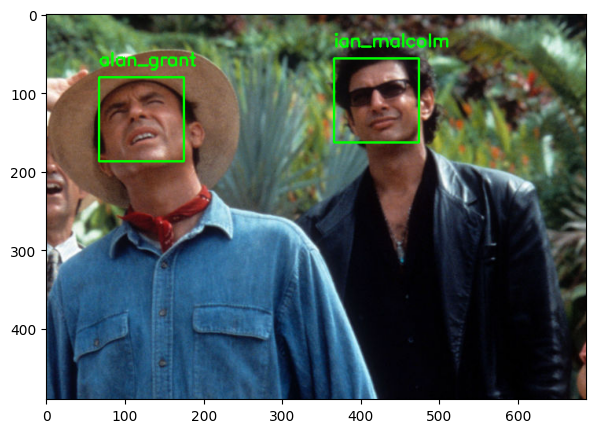

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(processed1)

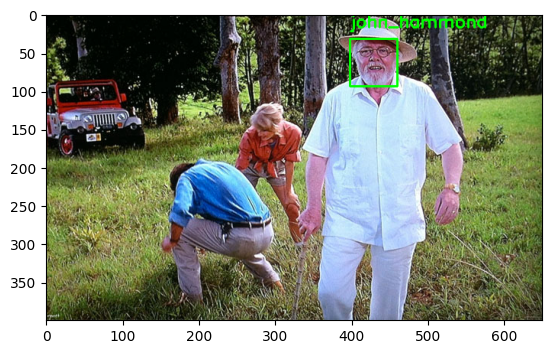

In [ ]:
plt.imshow(processed2)

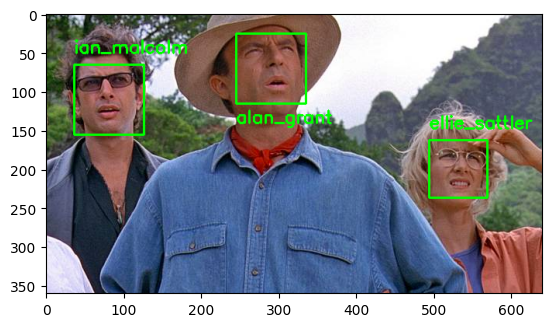

In [ ]:
plt.imshow(processed3)

# 5. Build a custom dataset
## Assignement
Here's what you are required to do for this part of the assignment.

- Build a dataset of reasonable size: a group of 10-15 people with 50-100 face pictures each, taken in different conditions of light, angle, emotion, etc.

- Apply the previously developed pipeline to build your own personalized face recognition system.

### Face detection

Notre dataset contient entre 50 à 80 photos de 8 personnes différentes
Nous avons au total plus de 500 images.

Renommons chaque image par leur label et un indice : 

On utilise la fonction os.walk() pour parcourir l'arbre menant au répertoire d'images. Pour chaque sous répertoire, le script boucle à travers chaque image et la renomme avec le nom du sous-répertoire comme préfixe + un numéro et les transforme au format jpg.

exemple : john_doe_1.jpg

In [ ]:
import os

# Chemin du répertoire
root_dir = "/content/drive/MyDrive/DeepLearning/data_perso"

# On boucle à travers tous les sous-répetoires
for dir_name, subdir_list, file_list in os.walk(root_dir):
    indice = 0
    # On boucle à travers chaque fichier du sous-répertoire
    for file_name in file_list:
        if (not file_name.endswith('.jpg')) or (not file_name.endswith('.jpeg')) or (not file_name.endswith('.png')) or file_name.endswith('.HEIC'):
            # Création du nouveau nom du fichier à partir du nom du répertoire
            new_file_name = os.path.join(dir_name, os.path.basename(dir_name) + '_' + str(indice)+'.HEIC')
            indice+=1
            # On renomme le fichier par le nouveau nom
            os.rename(os.path.join(dir_name, file_name), new_file_name)


In [ ]:
imagePaths = list_images("/content/drive/MyDrive/DeepLearning/data_perso_new")
imagePaths

['/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_41.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_42.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_40.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_39.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_38.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_36.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_37.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_35.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_4.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgacem_34.jpg',
 '/content/drive/MyDrive/DeepLearning/data_perso_new/amine_belgacem/amine_belgace

In [ ]:
faces, labels, names = [], [], []

for imagePath in imagePaths :
  #Extraction du label à partir du nom du fichier
  name = imagePath.split('/')[6]
  #Extraction du visage sur chaque image
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  face = extract_faces(image, model="cnn")
  #Cette condition s'assure qu'un visage ai bien été détecté
  if len(face) == 1:
    if name not in names :
      names.append(name)
    labels.append(name)
    faces+=face

In [ ]:
print(names)

['amine_belgacem', 'lina_aitamarouche', 'hafsa_boughemza', 'anthony_manuel', 'ryan_cassisi', 'nihad_nhar', 'john_doe', 'ines_djerba']


In [ ]:
from pickle import dump

file = open('dataset_perso', 'wb')
dump((faces, labels, names), file)
file.close()

On associe un numéro à chaque personne du dataset pour pouvoir utiliser la fonction to_categorical (pour le one hot encoding) qui ne fonctionne qu'avec
des entiers.

In [ ]:
#Associe un numéro à chaque noms
def name_to_int(names):
  number = [i for i in range(len(names))]
  return dict(zip(names,number))

In [ ]:
names_indexes = name_to_int(names)
print(names_indexes)

{'amine_belgacem': 0, 'lina_aitamarouche': 1, 'hafsa_boughemza': 2, 'anthony_manuel': 3, 'ryan_cassisi': 4, 'nihad_nhar': 5, 'john_doe': 6, 'ines_djerba': 7}


In [ ]:
category = [names_indexes[label] for label in labels]
category = to_categorical(category)
print(category)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Pose estimation

In [ ]:
from pickle import load

file = open('dataset_perso','rb')
faces,labels,names = load(file)

In [ ]:
print(names)

['amine_belgacem', 'lina_aitamarouche', 'hafsa_boughemza', 'anthony_manuel', 'ryan_cassisi', 'nihad_nhar', 'john_doe', 'ines_djerba']


In [ ]:
landmarks = face_landmarks(faces)

In [ ]:
new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

In [ ]:
aligned = align_faces(new_faces,landmarks)

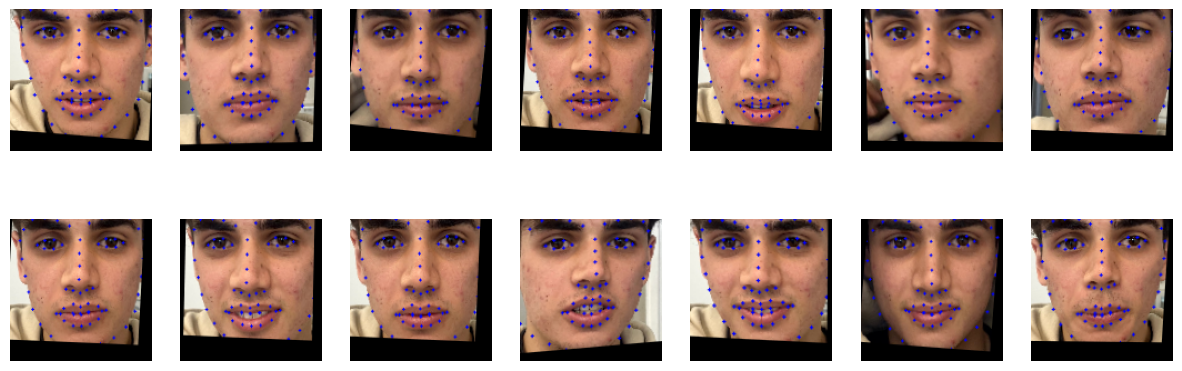

In [ ]:
show_grid(aligned[295:309], figsize=(15,5))

### Face encoding

In [ ]:
encoded_faces = face_encoder(faces)

In [ ]:
train_set_encoded, test_set_encoded, train_labels_encoded, test_labels_encoded = train_test_split(encoded_faces, category, train_size=0.7, shuffle=True) 

In [ ]:
model_encoded_perso = models.Sequential()
model_encoded_perso.add(layers.Dense(512, activation='relu', input_shape=(128,)))
model_encoded_perso.add(layers.Dense(128, activation='relu'))
model_encoded_perso.add(layers.Dense(64, activation='relu'))

model_encoded_perso.add(layers.Dense(8, activation='softmax'))
model_encoded_perso.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy']) # ADD CODE HERE


history = model_encoded_perso.fit(
    train_set_encoded, train_labels_encoded,
    validation_data=(test_set_encoded, test_labels_encoded),
    batch_size=32,
    epochs=50)

Epoch 1/50
12/12 [==============================] - 2s 76ms/step - loss: 2.0633 - accuracy: 0.1995 - val_loss: 2.0424 - val_accuracy: 0.3187
Epoch 2/50
12/12 [==============================] - 0s 29ms/step - loss: 2.0244 - accuracy: 0.3342 - val_loss: 2.0102 - val_accuracy: 0.2812
Epoch 3/50
12/12 [==============================] - 0s 20ms/step - loss: 1.9909 - accuracy: 0.3261 - val_loss: 1.9775 - val_accuracy: 0.2625
Epoch 4/50
12/12 [==============================] - 0s 25ms/step - loss: 1.9542 - accuracy: 0.3235 - val_loss: 1.9377 - val_accuracy: 0.2625
Epoch 5/50
12/12 [==============================] - 0s 20ms/step - loss: 1.9135 - accuracy: 0.3235 - val_loss: 1.8983 - val_accuracy: 0.2625
Epoch 6/50
12/12 [==============================] - 0s 26ms/step - loss: 1.8697 - accuracy: 0.3261 - val_loss: 1.8532 - val_accuracy: 0.2750
Epoch 7/50
12/12 [==============================] - 0s 21ms/step - loss: 1.8191 - accuracy: 0.3531 - val_loss: 1.8028 - val_accuracy: 0.3375
Epoch 8/50
12

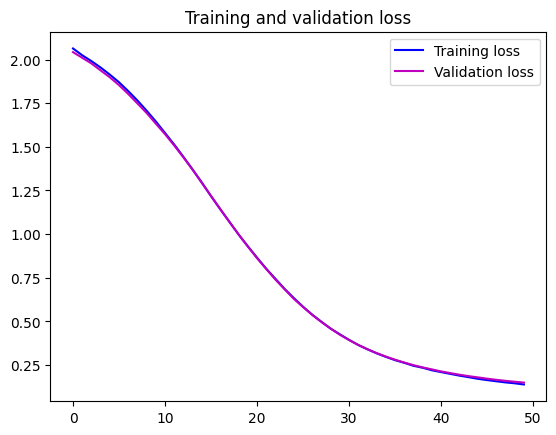

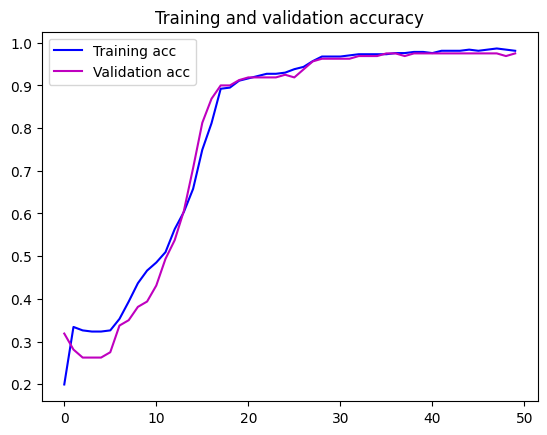

In [ ]:
# Get the training info
loss     = history.history['loss']
val_loss = history.history['val_loss']
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

# Visualize the history plots
plt.figure()
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'm', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(acc, 'b', label='Training acc')
plt.plot(val_acc, 'm', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### Test du modèle sur de nouvelles images

In [ ]:
test1 = cv2.imread("/content/drive/MyDrive/DeepLearning/data_perso_test/IMG_test1.jpg")
test2 = cv2.imread("/content/drive/MyDrive/DeepLearning/data_perso_test/IMG_test2.jpg")
test3 = cv2.imread("/content/drive/MyDrive/DeepLearning/data_perso_test/IMG_test3.png")
test4 = cv2.imread("/content/drive/MyDrive/DeepLearning/data_perso_test/IMG_test4.jpg")
test5 = cv2.imread("/content/drive/MyDrive/DeepLearning/data_perso_test/IMG_test5.jpg")

In [ ]:
processed1 = process_frame(test1.copy(),model_encoded_perso,names)
processed1= cv2.cvtColor(processed1, cv2.COLOR_BGR2RGB)

processed2 = process_frame(test2.copy(),model_encoded_perso,names)
processed2= cv2.cvtColor(processed2, cv2.COLOR_BGR2RGB)

processed3 = process_frame(test3.copy(),model_encoded_perso,names)
processed3= cv2.cvtColor(processed3, cv2.COLOR_BGR2RGB)

processed4 = process_frame(test4.copy(),model_encoded_perso,names)
processed4= cv2.cvtColor(processed4, cv2.COLOR_BGR2RGB)

processed5 = process_frame(test5.copy(),model_encoded_perso,names)
processed5= cv2.cvtColor(processed5, cv2.COLOR_BGR2RGB)

1/1 [==============================] - 0s 19ms/step


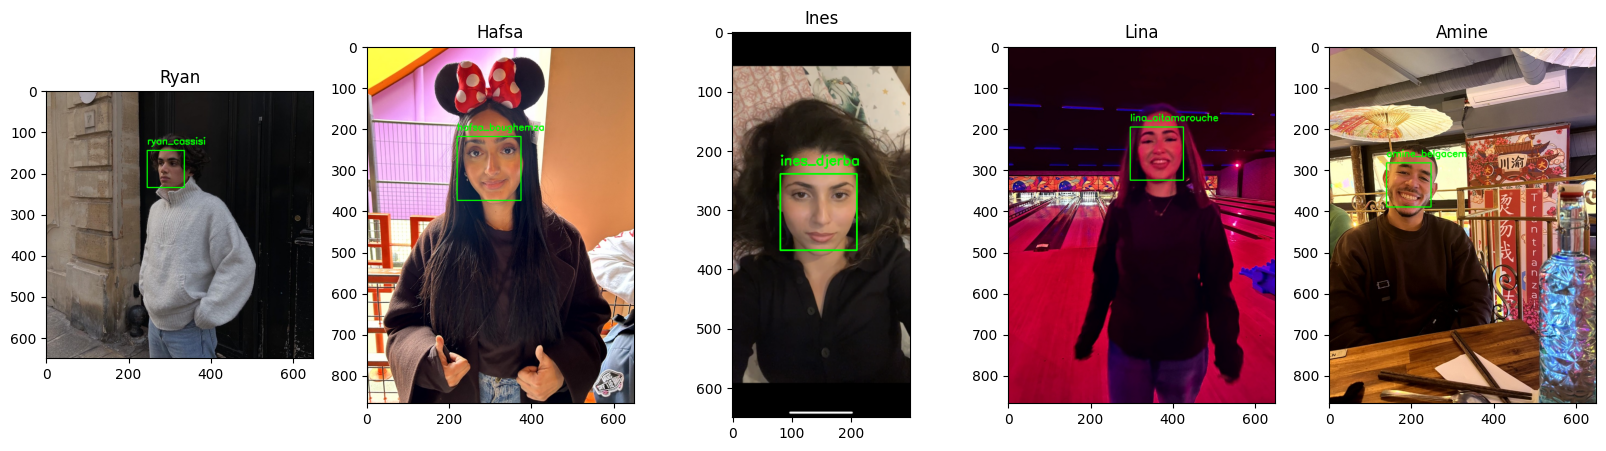

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

axes[0].imshow(processed1)
axes[0].set_title('Ryan')

axes[1].imshow(processed2)
axes[1].set_title('Hafsa')

axes[2].imshow(processed3)
axes[2].set_title('Ines')

axes[3].imshow(processed4)
axes[3].set_title('Lina')

axes[4].imshow(processed5)
axes[4].set_title('Amine')

plt.show()